In [1]:
import sys, os
sys.path.append('../')
sys.path.append('../src/')

import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
import torch.nn.functional as F

import torch.optim as opt
from torch import softmax, log_softmax, Tensor
from sklearn.cluster import KMeans
from scipy.sparse.linalg import svds
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from umap_batch import UMAP
from umap_batch import re_pairdis
from umap.utils import fast_knn_indices
from scipy.sparse import csr_matrix

import pandas as pd 
import numpy as np 
import scipy.sparse as sp
import torch
import model
import time

import quantile 

import coupleNMF as coupleNMF

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
# read in dataset
dir = '../data/real/diag/Xichen/'

counts_rnas = []
counts_atacs = []
counts_proteins = []
for batch in [1, 2]:
    try:
        counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
        counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

    except:
        counts_atac = None
        
    try:
        counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
        counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
    except:
        counts_rna = None
    
    # preprocess the count matrix
    counts_rnas.append(counts_rna)
    counts_atacs.append(counts_atac)

counts = {"rna":counts_rnas, "atac": counts_atacs}

A = sp.load_npz(os.path.join(dir, 'GxR.npz'))
A = np.array(A.todense())
interacts = {"rna_atac": A}


# obtain the feature name
genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

feats_name = {"rna": genes, "atac": regions}
counts["feats_name"] = feats_name



# # Even transform in advance, the performance is still not good.
# # read in dataset
# dir = '../data/real/diag/Xichen/'

# counts_rnas = []
# counts_atacs = []
# counts_proteins = []
# for batch in [1, 2]:
#     try:
#         counts_atac = np.array(sp.load_npz(os.path.join(dir, 'RxC' + str(batch) + ".npz")).todense().T)
#         counts_atac = utils.preprocess(counts_atac, modality = "ATAC")

#     except:
#         counts_atac = None
        
#     try:
#         counts_rna = np.array(sp.load_npz(os.path.join(dir, 'GxC' + str(batch) + ".npz")).todense().T)
#         counts_rna = utils.preprocess(counts_rna, modality = "RNA")
    
#     except:
#         counts_rna = None
    
#     # preprocess the count matrix
#     counts_rnas.append(counts_rna)
#     counts_atacs.append(counts_atac)


# counts_rnas[1] = counts_atacs[1] @ A.T
# counts = {"rna":counts_rnas}

# interacts = None

# # obtain the feature name
# genes = pd.read_csv(dir + "genes.txt", header = None).values.squeeze()
# regions = pd.read_csv(dir + "regions.txt", header = None).values.squeeze()

# counts["feats_name"] = {"rna": genes}
# counts["feats_name"] = feats_name



In [24]:
#hyper parameters: best lr = 5e-3, T = 4000, latent_dims = 13
alpha = [1000, 1, 100, 100, 0.00]
batchsize = 0.1
run = 0
K = 8
Ns = [K] * 2
N_feat = Ns[0]
interval = 100
T = 4000
lr = 1e-2

In [25]:
# didn't use the interaction matrix
model1 = model.cfrm_new(counts = counts, interacts = interacts, Ns = Ns, K = K, N_feat = N_feat, 
                        batch_size = batchsize, interval = interval, lr = lr, alpha = alpha, seed = run).to(device)
losses1 = model1.train_func(T = T, T1 = None)

Input sanity check...
Finished.
Epoch 100, Validating Loss: -173.2527
	 loss 1: 89.31425
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: -62.56709
	 loss 5: 0.00000
Epoch 200, Validating Loss: -174.1075
	 loss 1: 89.30061
	 loss 2: 0.00000
	 loss 3: -199.99986
	 loss 4: -63.40827
	 loss 5: 0.00000
Epoch 300, Validating Loss: -175.8093
	 loss 1: 89.16904
	 loss 2: 0.00000
	 loss 3: -199.99971
	 loss 4: -64.97859
	 loss 5: 0.00000
Epoch 400, Validating Loss: -179.5438
	 loss 1: 87.77003
	 loss 2: 0.00000
	 loss 3: -199.99802
	 loss 4: -67.31585
	 loss 5: 0.00000
Epoch 500, Validating Loss: -183.6394
	 loss 1: 85.86860
	 loss 2: 0.00000
	 loss 3: -199.99844
	 loss 4: -69.50960
	 loss 5: 0.00000
Epoch 600, Validating Loss: -186.3772
	 loss 1: 85.22324
	 loss 2: 0.00000
	 loss 3: -199.99925
	 loss 4: -71.60123
	 loss 5: 0.00000
Epoch 700, Validating Loss: -188.5407
	 loss 1: 84.82301
	 loss 2: 0.00000
	 loss 3: -199.99944
	 loss 4: -73.36427
	 loss 5: 0.00000
Epoch 800, Validating Loss: -1

In [26]:
# assigning cell clusters and gene clusters
model1.assign_clusters(n_relocate = None)


assigning cell clusters...
assigning feature clusters...
binarizing association matrix...


## Visualize cell embedding
Extract cell factor and perform UMAP visualization

In [27]:
zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(0,2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    # z = model1.C_cells[batch].cpu().detach().numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())
    
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4, random_state = 0) 
x_umap = umap_op.fit_transform(np.concatenate(zs, axis = 0))
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

### Ground truth labeling

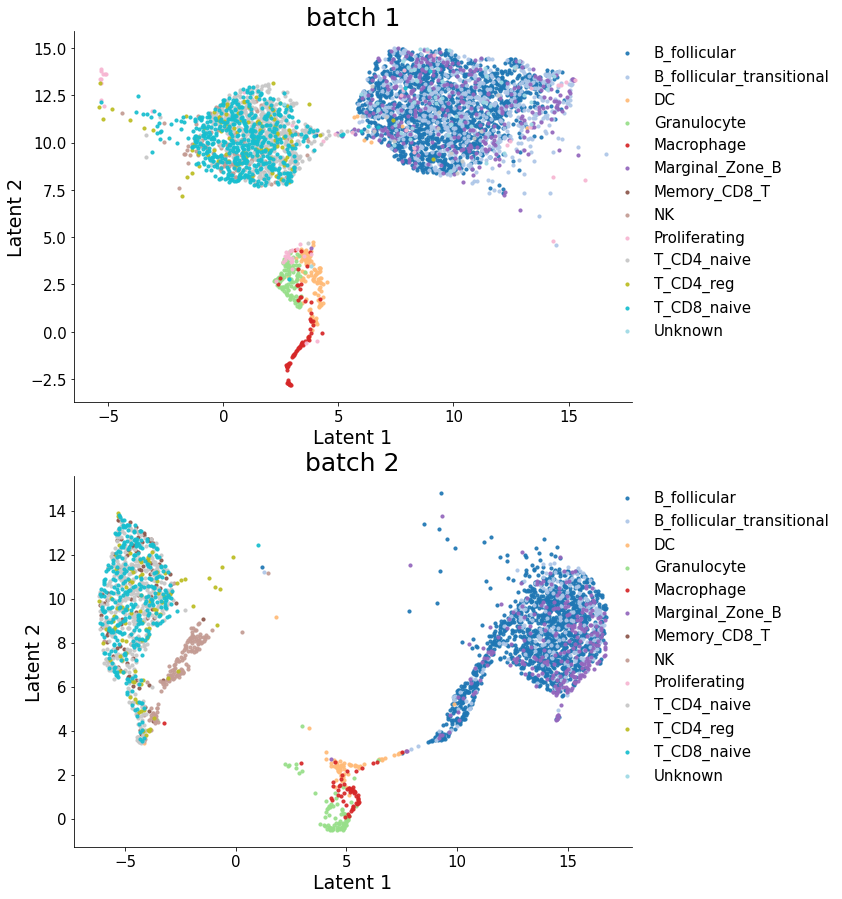

In [28]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")


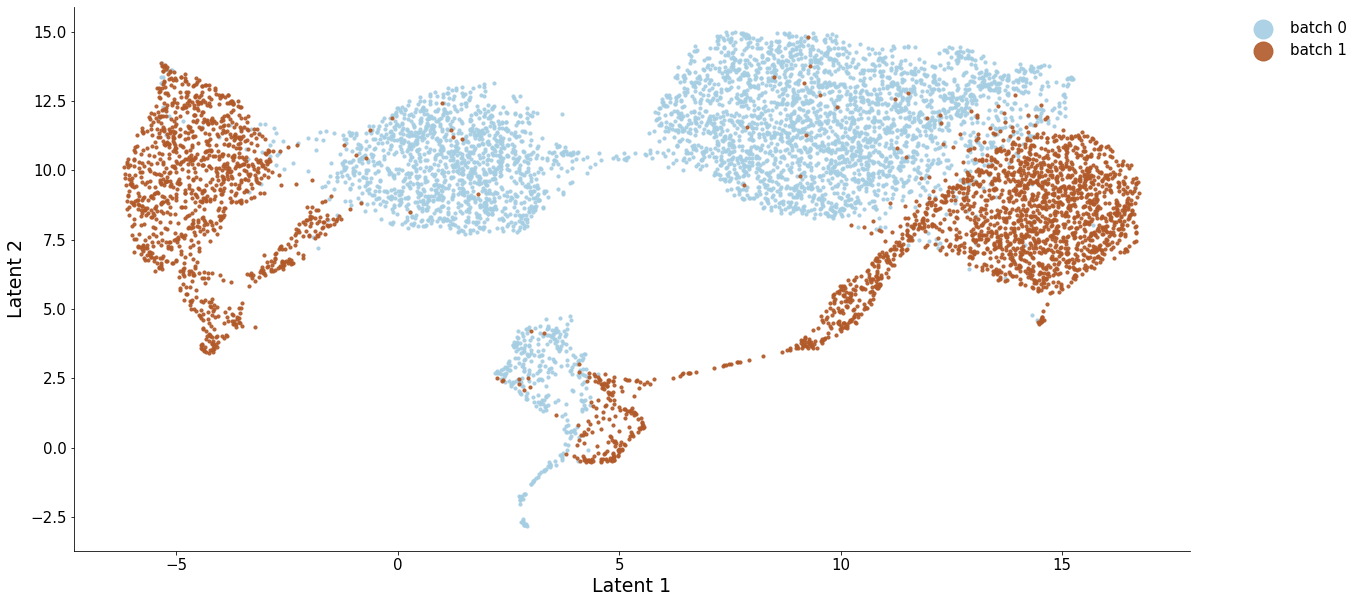

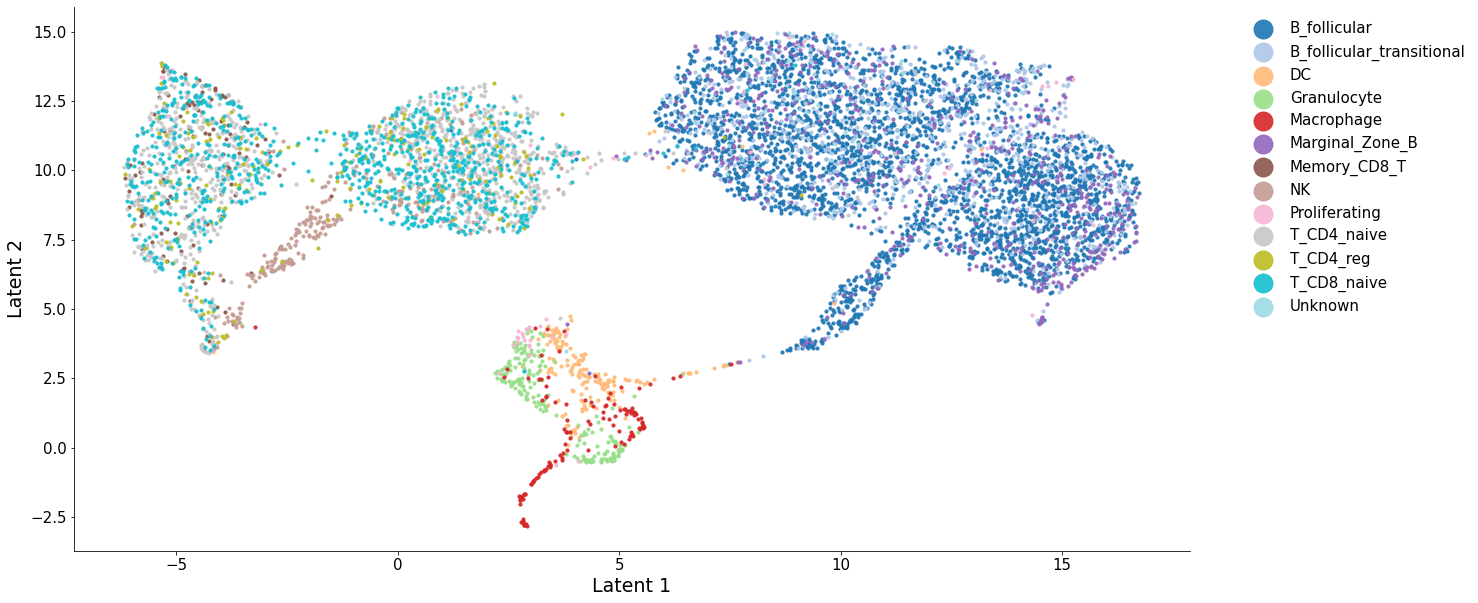

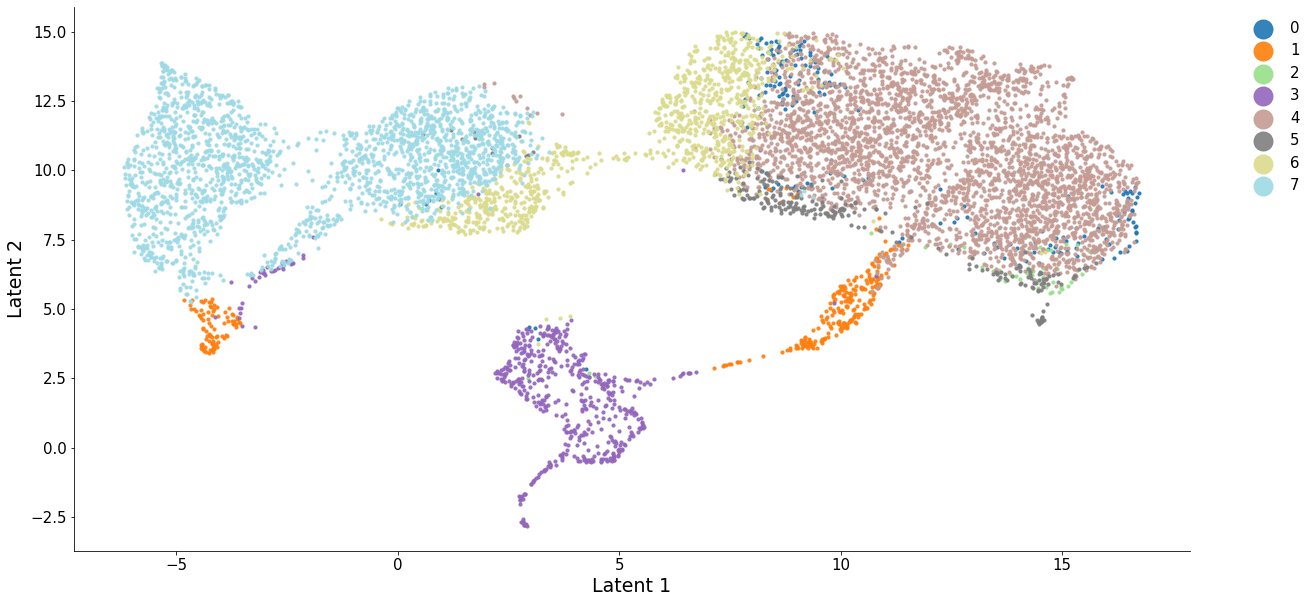

In [29]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


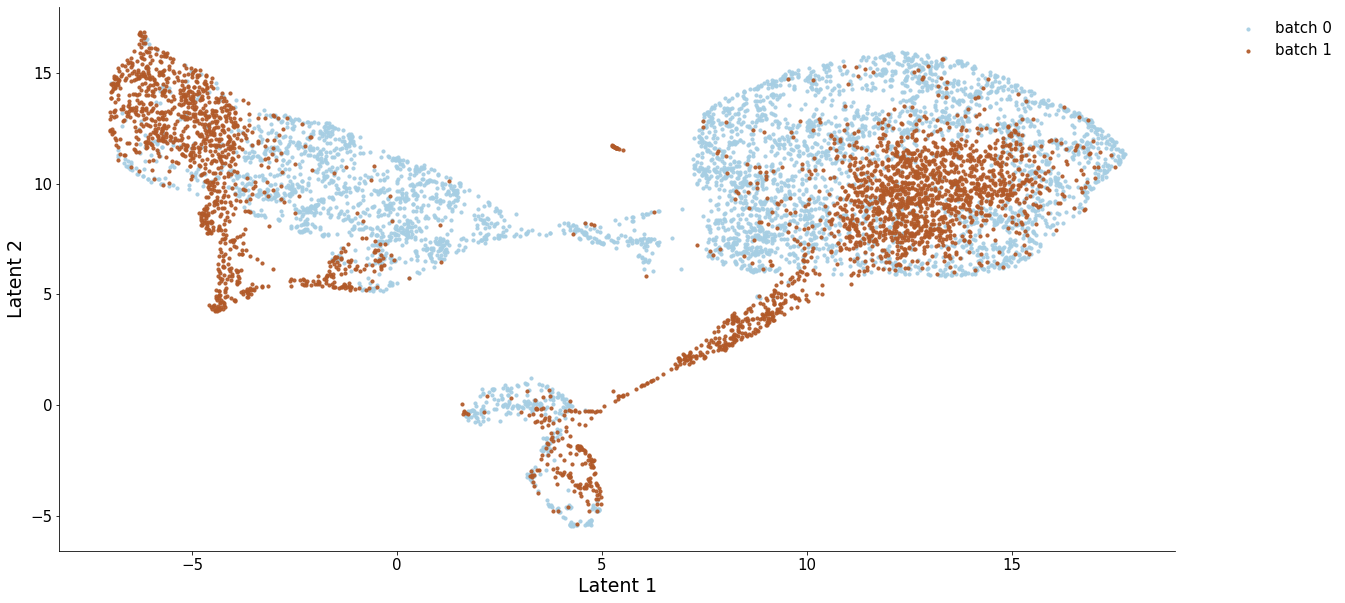

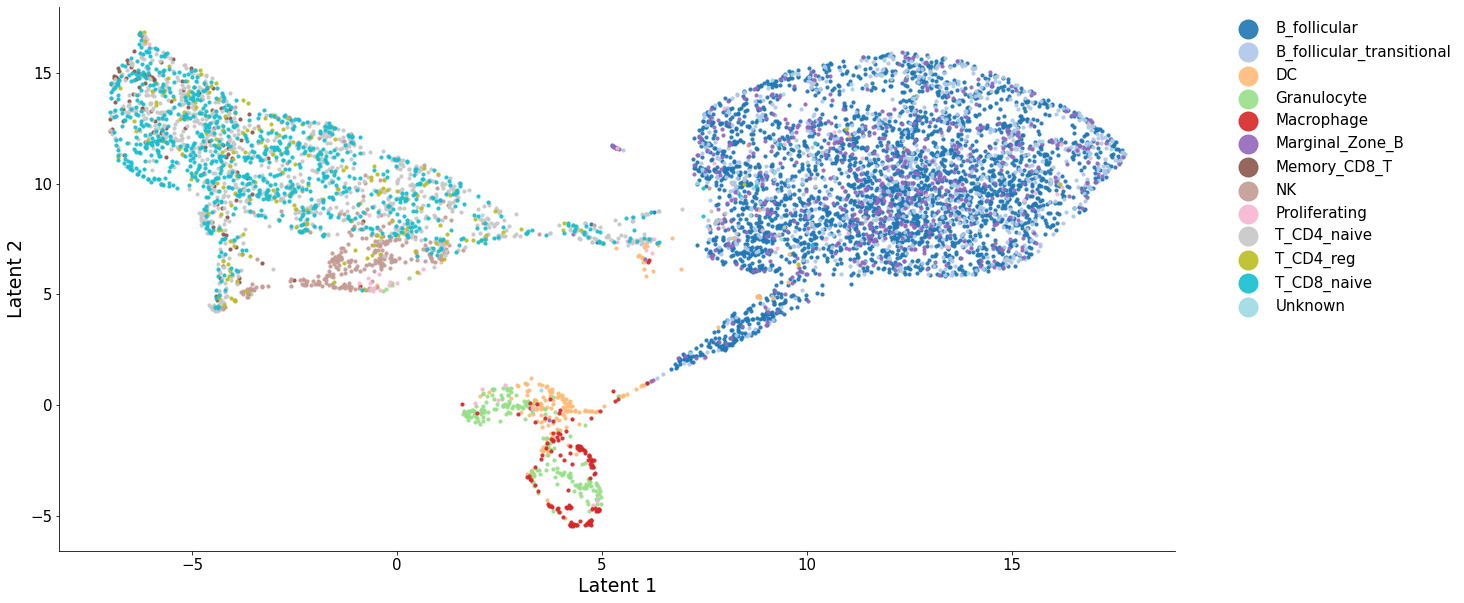

In [30]:
# scDART flavor

zs = []
labels = []
prec_labels = []
pre_labels = []
for batch in range(2):
    z = model1.softmax(model1.C_cells[batch].cpu().detach()).numpy()
    zs.append(z)
    labels.append(pd.read_csv(os.path.join(dir, 'meta_c' + str(batch + 1) + '.csv'), index_col=0)["cell_type"].values.squeeze())
    pre_labels.append(np.argmax(z, axis = 1).squeeze())

    
zs2 = utils.match_embeds(zs, k = 10, reference = 1, bandwidth = 40)

x_umap = umap_op.fit_transform(np.concatenate(zs2, axis = 0))
# separate into batches
x_umaps = []
for batch in range(2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs2[batch - 1].shape[0]
        end_pointer = start_pointer + zs2[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent")


utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


# Modify pairwise distances

## Method I modify block by block

In [31]:
# get a pairwise distance matrix
pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))


# get the matrix who has the largest numbers of elements as the reference matrix
start_point, end_point = [], []
maxnum, maxbatch, start, number = 0, 0, 0, 0

for batch in range(len(zs)):
    start_point.append(start)
    number = len(zs[batch])
    start += number
    end = start-1
    end_point.append(end)
    if number > maxnum:
        maxnum = start
        maxbatch = batch

# regard the largest matrix as the reference matrix
ref_dis = pair_dist[start_point[maxbatch]:end_point[maxbatch]+1, 
                    start_point[maxbatch]:end_point[maxbatch]+1].flatten()


# Modify blocks
i = 0
p = np.zeros((len(pair_dist), len(pair_dist)), dtype=np.float32)
for rows in range(len(zs)):
    for batch in range(i, len(zs)):
        if [rows, batch] != [maxbatch, maxbatch]:
            blocks = pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1].flatten()
            d = np.argsort(blocks)
            blocks[d] = list(range(len(d)))

            sample = np.random.choice(ref_dis, len(d), replace=False)
            sample.sort()

            blocks = sample[blocks.astype(int)]
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = np.reshape(blocks,
                                    (end_point[rows]+1-start_point[rows], end_point[batch]+1-start_point[batch]))
        else:
            p[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1] = \
                pair_dist[start_point[rows]:end_point[rows]+1, start_point[batch]:end_point[batch]+1]
    i += 1
    
p = np.triu(p)
p += p.T - np.diag(p.diagonal())
np.fill_diagonal(p, 0)
s_pair_dist = csr_matrix(p)

In [32]:
aft_mean = np.zeros((len(zs), len(zs)))

for row in range(len(zs)):
    for col in range(len(zs)):
        block = p[start_point[row]:end_point[row]+1, start_point[col]:end_point[col]+1]
        mean = np.mean(block)
        aft_mean[row, col] = mean

aft_mean

array([[0.28987634, 0.28992274],
       [0.28992274, 0.28986451]])

../src/umap_batch.py:1743: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


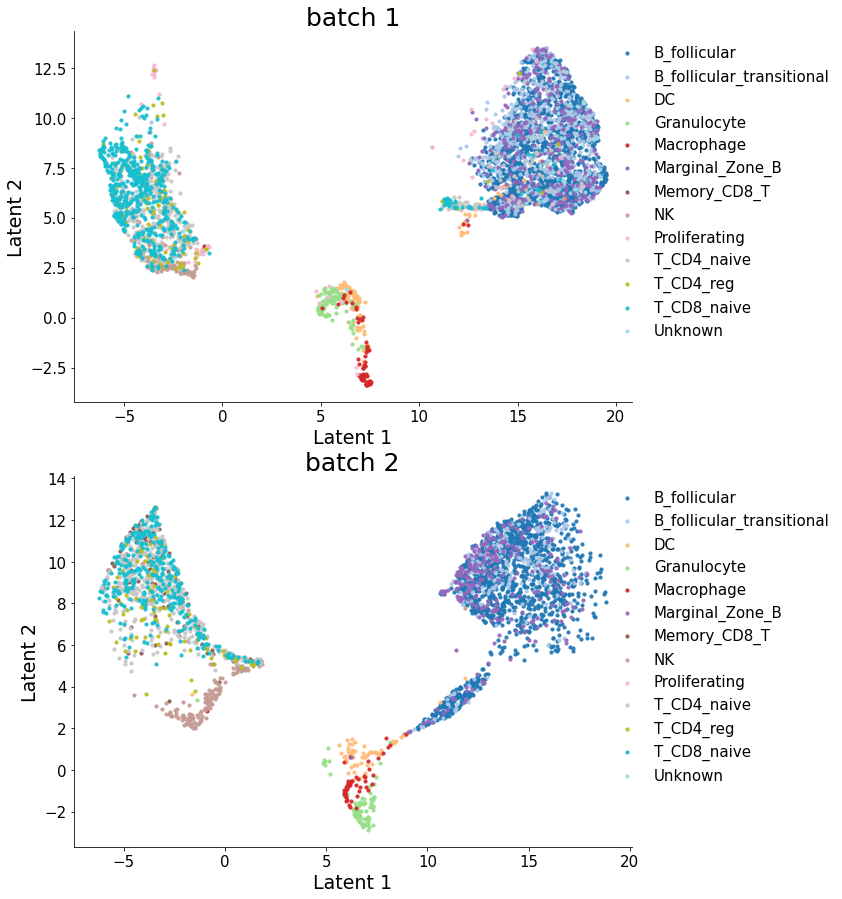

In [33]:
umap_op = UMAP(n_components = 2, n_neighbors = 25, min_dist = 0.4, random_state = 0, metric='precomputed') 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 1:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")



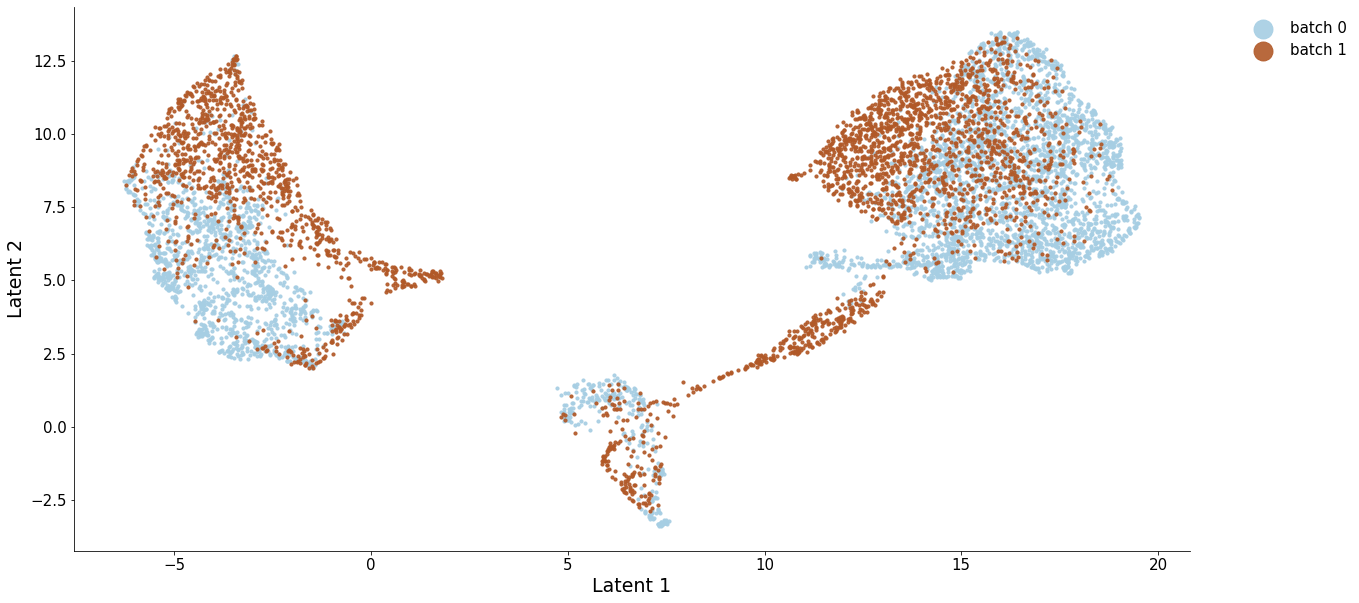

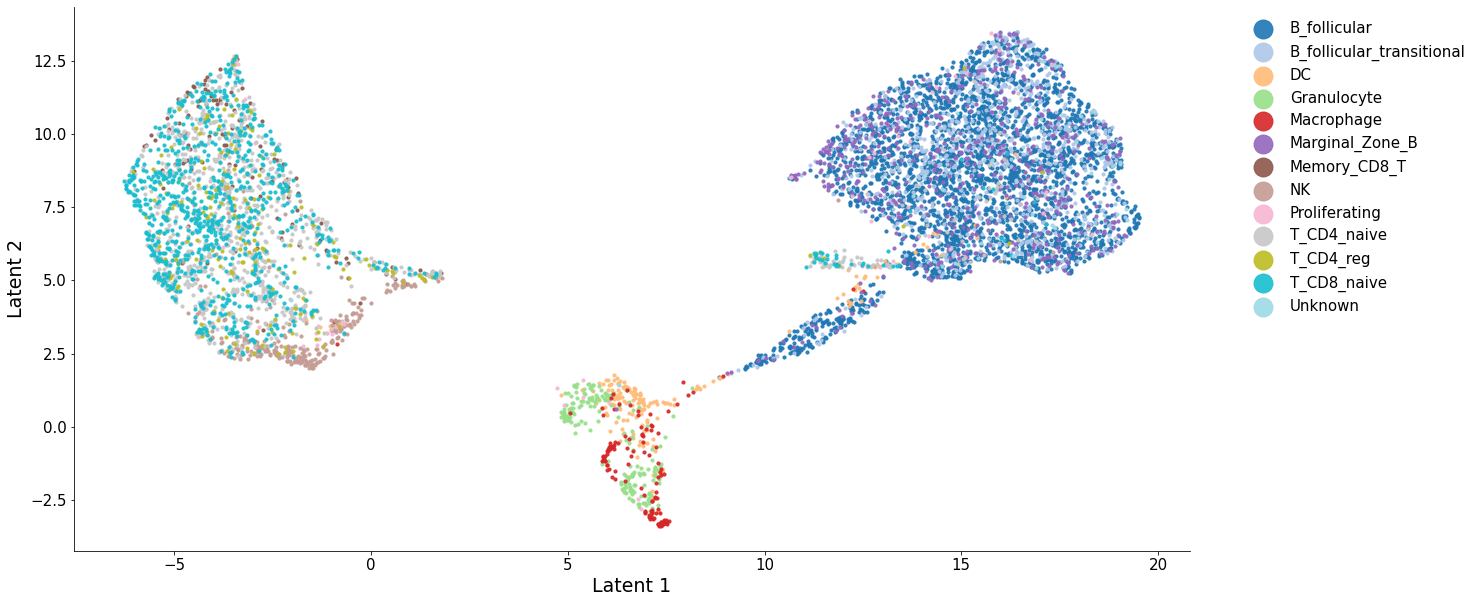

In [34]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)


### Assign knn_indices for UMAP

In [35]:
# get a pairwise distance matrix
pair_dist = p

# Define n_neighbors in UMAP
n_neighbors = 12

# get the start points, end points and size for each batch
start_point, end_point, b_size, b_ratios = [], [], [], []
start = 0

for batch in range(len(zs)):
    start_point.append(start)
    b_size.append(len(zs[batch]))
    b_ratios.append(len(zs[batch])/len(pair_dist)) 
    start += len(zs[batch])
    end_point.append(start-1)

b_neighbors = np.random.multinomial(n_neighbors, b_ratios)


knn_indices = np.zeros((len(pair_dist), n_neighbors))
for batch in range(len(zs)):
    knn_indices[:, sum(b_neighbors[0:batch]):sum(b_neighbors[0:batch+1])] = \
                fast_knn_indices(pair_dist[:, start_point[batch]:end_point[batch]+1],
                                 b_neighbors[batch]) + start_point[batch]

knn_indices = knn_indices.astype(int)
knn_dists = pair_dist[np.arange(pair_dist.shape[0])[:, None], knn_indices].copy()


In [36]:
umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.3, random_state = 0, 
                metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices) 
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")



../src/umap_batch.py:1743: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


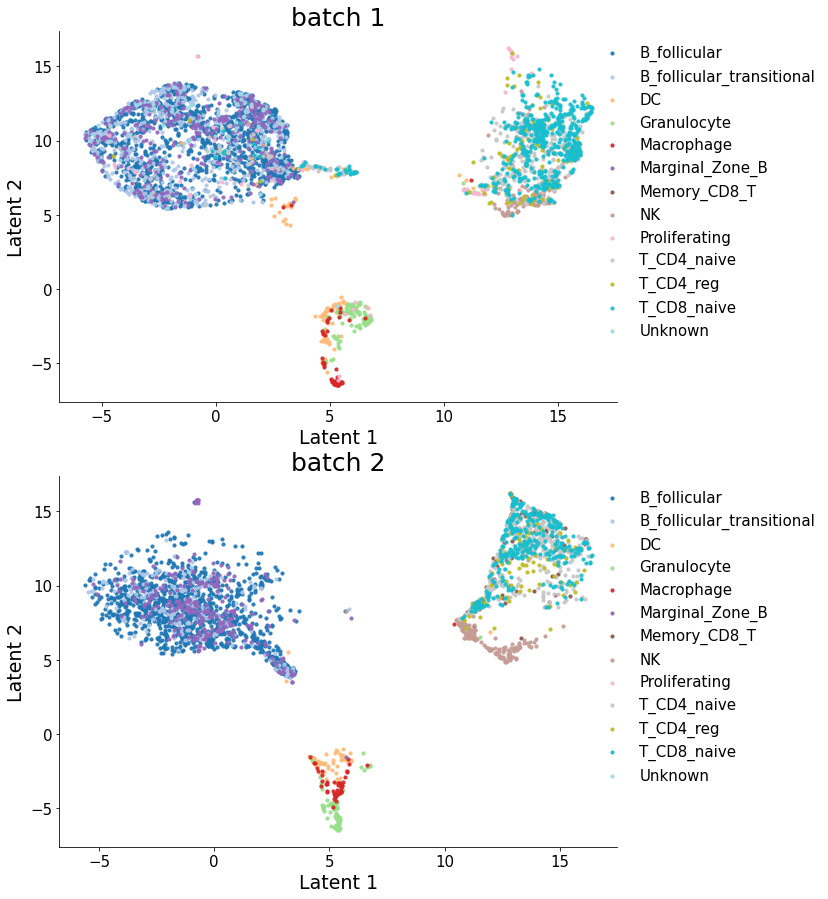

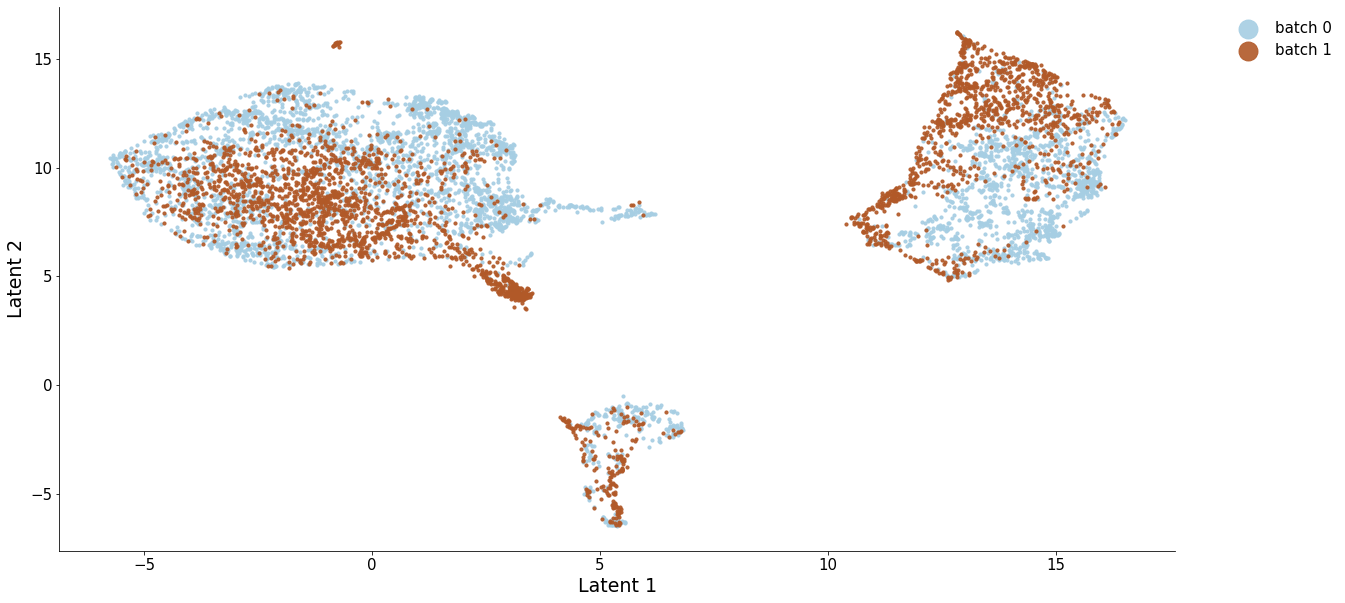

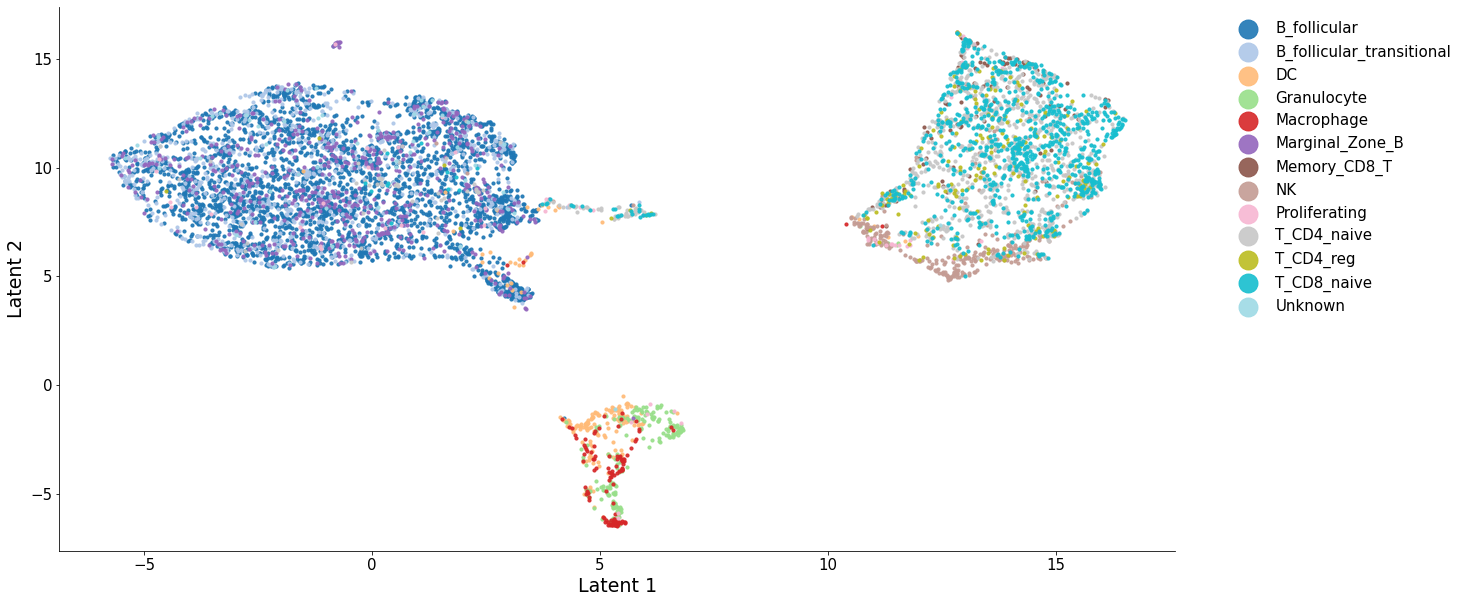

In [37]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, 
                      figsize = (10,15), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)



# Only assign knn_indices for UMAP

In [85]:
# get a pairwise distance matrix
pair_dist = squareform(pdist(np.concatenate(zs, axis=0)))
s_pair_dist = csr_matrix(pair_dist)

# Define n_neighbors in UMAP
n_neighbors = 8

# get the start points, end points and size for each batch
start_point, end_point, b_size, b_ratios = [], [], [], []
start = 0

for batch in range(len(zs)):
    start_point.append(start)
    b_size.append(len(zs[batch]))
    b_ratios.append(len(zs[batch])/len(pair_dist)) 
    start += len(zs[batch])
    end_point.append(start-1)

b_neighbors = np.random.multinomial(n_neighbors, b_ratios)

knn_indices = np.zeros((len(pair_dist), n_neighbors))
for batch in range(len(zs)):
    knn_indices[:, sum(b_neighbors[0:batch]):sum(b_neighbors[0:batch+1])] = fast_knn_indices(pair_dist[:, start_point[batch]:end_point[batch]+1], b_neighbors[batch]) + start_point[batch]

knn_indices = knn_indices.astype(int)
knn_dists = pair_dist[np.arange(pair_dist.shape[0])[:, None], knn_indices].copy()


../src/umap_batch.py:1743: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  warn(


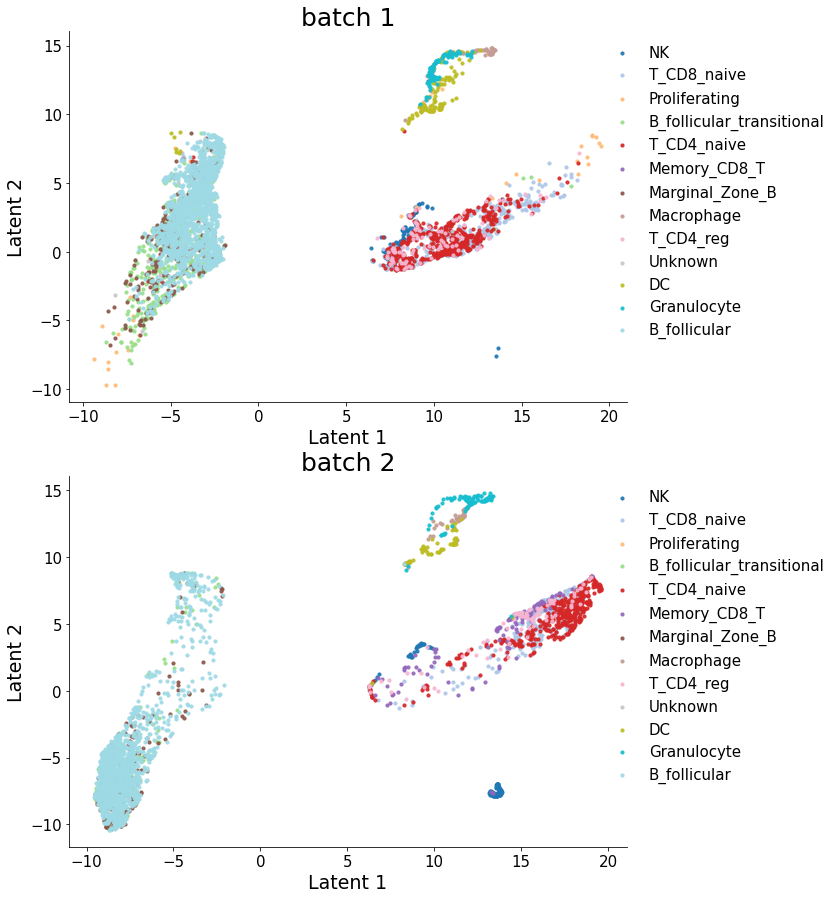

In [86]:
umap_op = UMAP(n_components = 2, n_neighbors = n_neighbors, min_dist = 0.3, random_state = 0, metric='precomputed', knn_dists=knn_dists, knn_indices=knn_indices)
x_umap = umap_op.fit_transform(s_pair_dist)
# separate into batches
x_umaps = []
for batch in range(0,2):
    if batch == 0:
        start_pointer = 0
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])
    elif batch == 3:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        x_umaps.append(x_umap[start_pointer:,:])
    else:
        start_pointer = start_pointer + zs[batch - 1].shape[0]
        end_pointer = start_pointer + zs[batch].shape[0]
        x_umaps.append(x_umap[start_pointer:end_pointer,:])

# utils.plot_latent_ext(x_umaps, annos = prec_labels, mode = "separate", save = None, figsize = (10,30), axis_label = "Latent")

utils.plot_latent_ext(x_umaps, annos = labels, mode = "separate", save = None, figsize = (10,15), axis_label = "Latent")



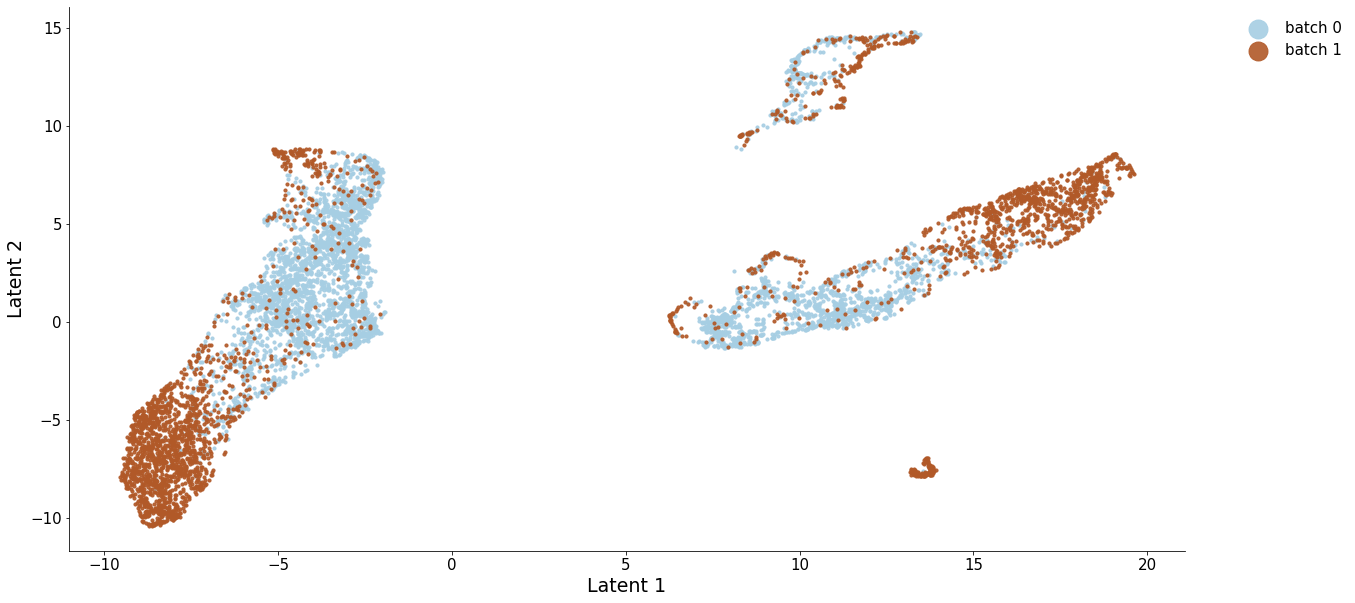

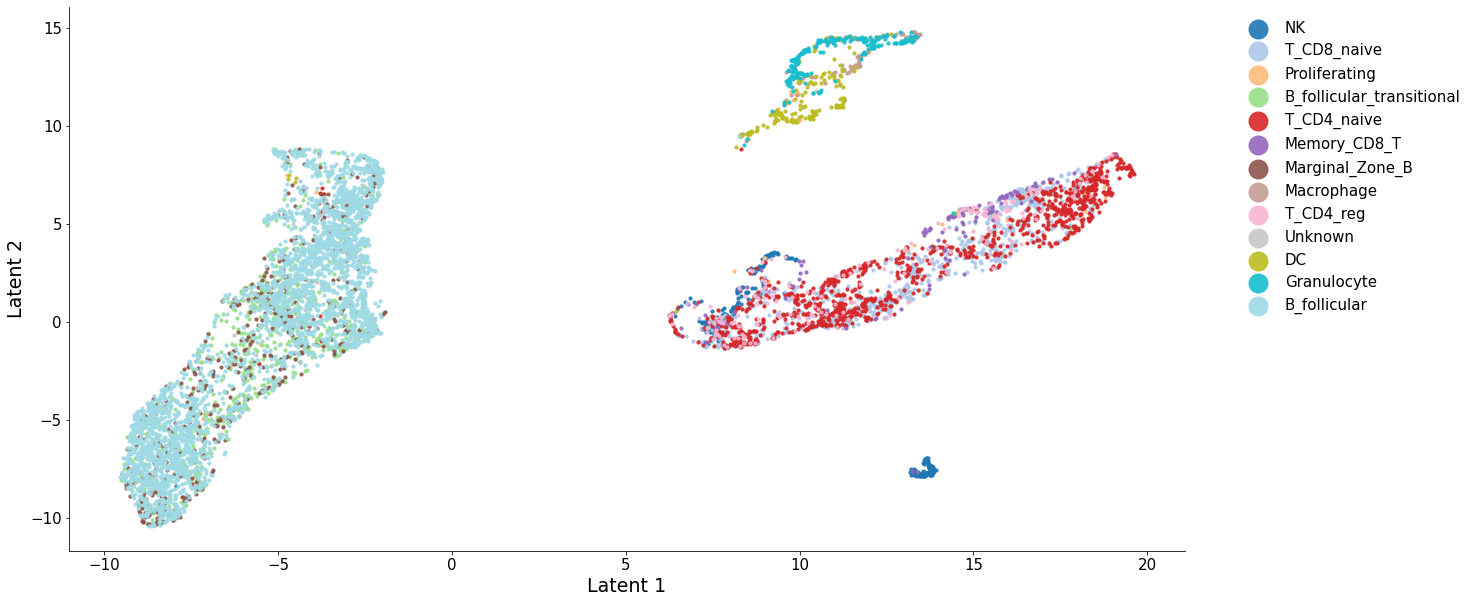

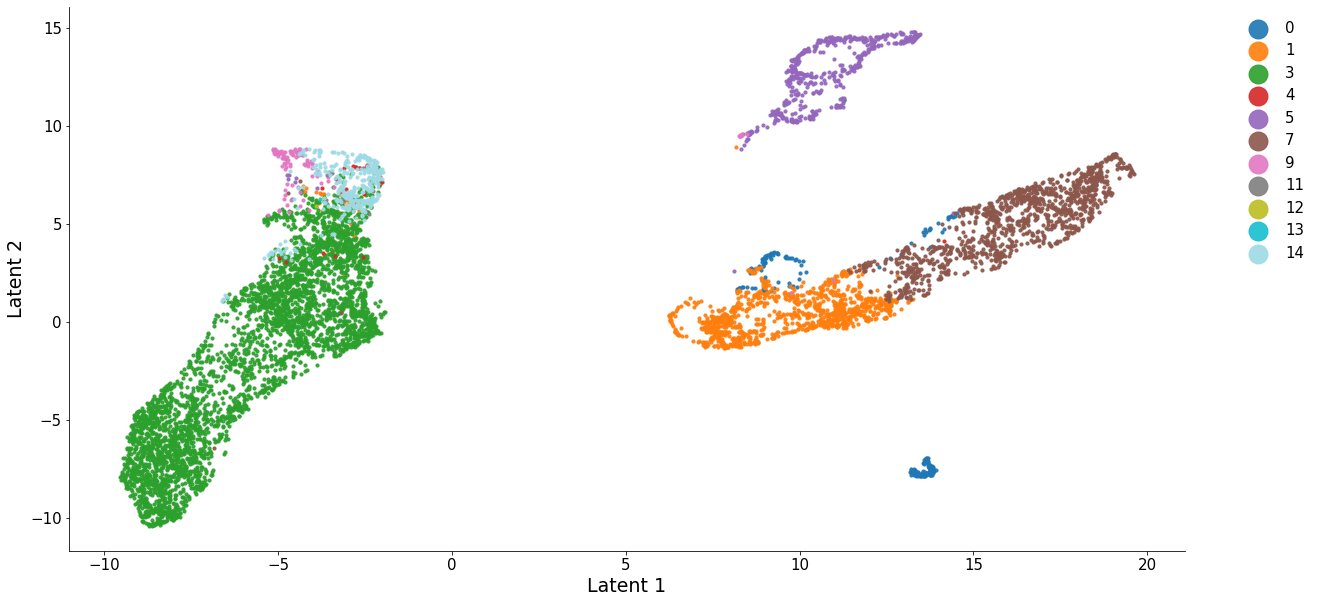

In [87]:
utils.plot_latent_ext(x_umaps, annos = labels, mode = "modality", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)

utils.plot_latent_ext(x_umaps, annos = pre_labels, mode = "joint", save = None, 
                      figsize = (20,10), axis_label = "Latent", markerscale = 6)